In [1]:
import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("../data/mu-frac-iron-shower-signals.csv")
x_columns = df.columns[2:-2]
y_columns = df.columns[-2:]

In [26]:
CLASSIFY_FIRST = False

FILTER = True
FILTER_BY = 'S'
FILTER_GREATER_THAN = 1.5

In [27]:
X = df[x_columns].to_numpy()
y = df[y_columns].to_numpy()

y = np.mean(y, axis=1)
y = np.maximum(y, 0)
mask = None

if CLASSIFY_FIRST:
    classifier = xgb.Booster()
    classifier.load_model("../trained_models/xgboost-classifier.model")
    dall = xgb.DMatrix(X)
    class_predicted = classifier.predict(dall)
    mask = class_predicted < 0.5

if FILTER:
    mask = df[FILTER_BY] > FILTER_GREATER_THAN


if mask is not None:
    X = X[mask, :]
    y = y[mask]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


In [28]:
def calculate_weight(muon_fraction: float) -> float:
    return 1 / (2 - muon_fraction)

dtrain = xgb.DMatrix(X_train, label=y_train, weight=np.array([calculate_weight(y_) for y_ in y_train]))
dtest = xgb.DMatrix(X_test, label=y_test, weight=np.array([calculate_weight(y_) for y_ in y_test]))

In [29]:
param = {
    'max_depth': 8,
    'learning_rate': 0.05,
    'min_child_weight': 3.0,
    'subsample': 0.8,
    'objective': 'reg:squarederror',
}

epochs = 500

In [30]:
model = xgb.train(param, dtrain, num_boost_round=epochs, evals=[(dtest, 'test')], verbose_eval=5, early_stopping_rounds=15)

[0]	test-rmse:0.27934
[5]	test-rmse:0.24426
[10]	test-rmse:0.22018
[15]	test-rmse:0.20404
[20]	test-rmse:0.19338
[25]	test-rmse:0.18644
[30]	test-rmse:0.18195
[35]	test-rmse:0.17899
[40]	test-rmse:0.17702
[45]	test-rmse:0.17575
[50]	test-rmse:0.17486
[55]	test-rmse:0.17426
[60]	test-rmse:0.17385
[65]	test-rmse:0.17358
[70]	test-rmse:0.17340
[75]	test-rmse:0.17324
[80]	test-rmse:0.17319
[85]	test-rmse:0.17311
[90]	test-rmse:0.17304
[95]	test-rmse:0.17300
[100]	test-rmse:0.17294
[105]	test-rmse:0.17290
[110]	test-rmse:0.17287
[115]	test-rmse:0.17285
[120]	test-rmse:0.17283
[125]	test-rmse:0.17283
[130]	test-rmse:0.17282
[135]	test-rmse:0.17279
[140]	test-rmse:0.17279
[145]	test-rmse:0.17280
[150]	test-rmse:0.17281
[153]	test-rmse:0.17281


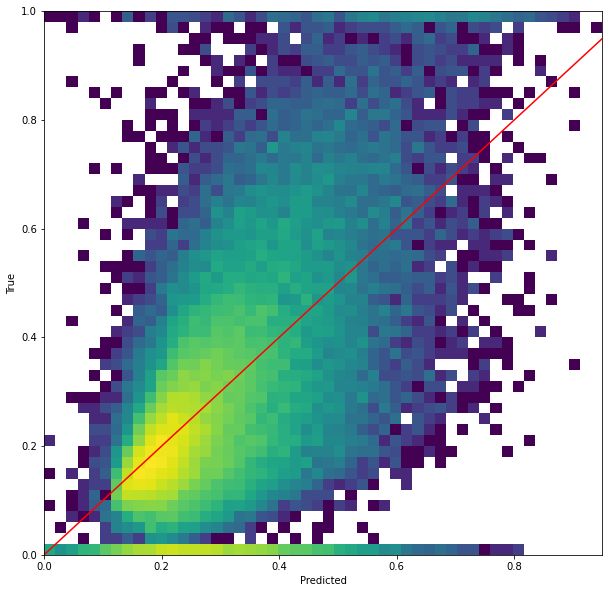

In [31]:
y_pred = model.predict(dtest)
y_pred = np.maximum(y_pred, 0)
y_pred = np.minimum(y_pred, 1)
y_true = dtest.get_label()

from matplotlib.colors import LogNorm

fig, ax = plt.subplots(figsize=(10, 10))

ax.hist2d(y_pred, y_true, bins=50, norm=LogNorm())
ax.set_xlabel("Predicted")
ax.set_ylabel("True")
ax.plot([0, 1], [0, 1], color='red')

# plt.savefig(f"../pics/xgboost-evaluation-{param['objective']}.png", bbox_inches='tight')

# Prediction error

In [32]:
N_BINS = 15
QUANTILE = 0.1

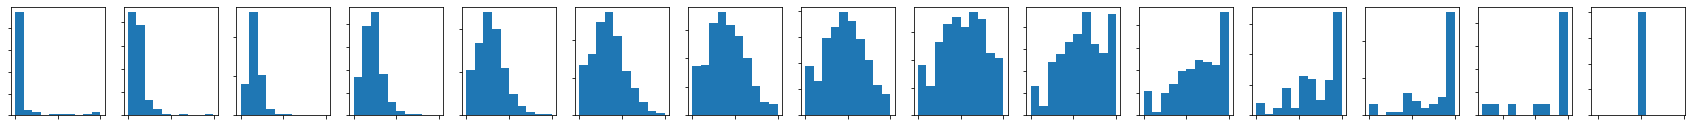

In [33]:
bin_edges = np.linspace(0, 1, N_BINS + 1)

fig, axes = plt.subplots(nrows=1, ncols=N_BINS, figsize=(30, 2))

predicted = []
true_mean = []
true_lower_cl = []
true_upper_cl = []

for idx, (bin_edge_l, bin_edge_r) in enumerate(zip(bin_edges[:-1], bin_edges[1:])):
    predicted_in_range_mask = np.logical_and(y_pred >= bin_edge_l, y_pred <= bin_edge_r)
    true_for_predicted_in_range = y_true[predicted_in_range_mask]
    ax: plt.Axes = axes[idx]
    ax.hist(true_for_predicted_in_range)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    predicted.append(0.5 * (bin_edge_l + bin_edge_r))
    true_mean.append(np.mean(true_for_predicted_in_range))
    true_lower_cl.append(np.quantile(true_for_predicted_in_range, QUANTILE))
    true_upper_cl.append(np.quantile(true_for_predicted_in_range, 1 - QUANTILE))

predicted = np.array(predicted)
true_mean = np.array(true_mean)
true_lower_cl = np.array(true_lower_cl)
true_upper_cl = np.array(true_upper_cl)

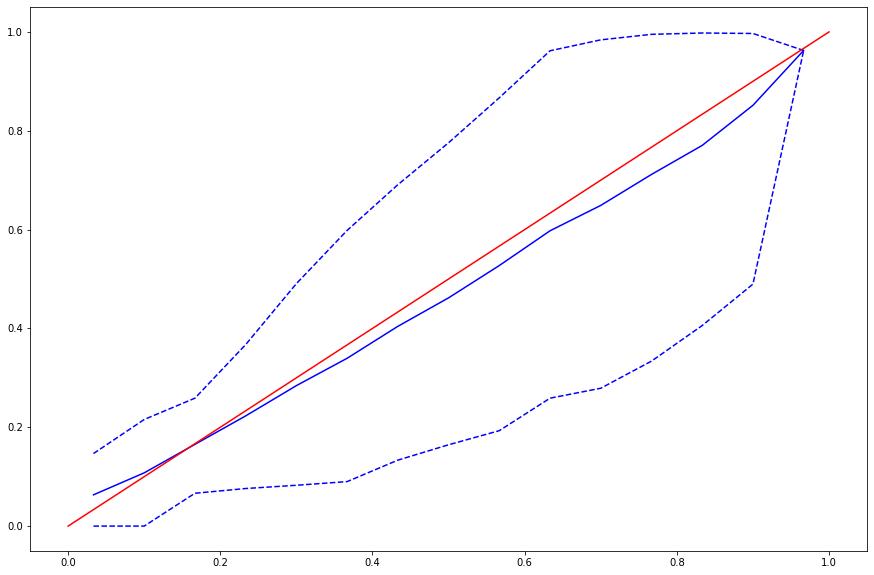

In [34]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(predicted, true_mean, 'b-')
ax.plot(predicted, true_upper_cl, 'b--')
ax.plot(predicted, true_lower_cl, 'b--')

ax.plot([0, 1], [0, 1], color='red')